In [282]:
%matplotlib inline
import time
import glob
import re
from functools import reduce


import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
import pandas as pd
import uproot
import uproot_methods
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# https://arxiv.org/abs/1107.3084

In [283]:
class EventProcessor(processor.ProcessorABC):
    def __init__(self):
        d = {"counts": processor.defaultdict_accumulator(int)}
        for k in ["zmass","nmass","hmass","zpt","npt","hpt"]:
            d[k] = processor.column_accumulator(np.zeros(shape=(0,)))
        self._accumulator = processor.dict_accumulator(d)
            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        year = int(re.search("(201.)",dataset).groups()[0])

        muons = uproot_methods.TLorentzVectorArray.from_ptetaphim(
            df["Muon_pt"],df["Muon_eta"],df["Muon_phi"],df["Muon_mass"]
        )
        muons["charge"] = df["Muon_charge"]
        muons["isgood"] = (df["Muon_mediumId"] 
                          & (df["Muon_miniIsoId"] > 0)
                          & (np.abs(muons.eta) < 3.0) 
                          & (muons.pt > 10.))
        output["counts"]["total"] += len(muons)
        muons = muons[muons["isgood"]]
        
        muons = muons[
            (muons.counts==4)
            & (muons.charge.sum()==0)
                  ]
        
        if not len(muons):
            return output
        
        mm = muons.distincts()
        imm = muons.argdistincts()
        isos = (mm.i0.charge*mm.i1.charge < 0)
        mm = mm[isos]
        imm = imm[isos]

        zidx = np.abs((mm.i0+mm.i1).mass-91.2).argmin()
        
        nidx = ((imm.i0 != imm[zidx].i0[:,0]) 
              & (imm.i0 != imm[zidx].i1[:,0])
              & (imm.i1 != imm[zidx].i0[:,0])
              & (imm.i1 != imm[zidx].i1[:,0])).argmax()
        zp4 = (mm.i0+mm.i1)[zidx]
        np4 = (mm.i0+mm.i1)[nidx]
        hp4 = zp4+np4
        
        output["zmass"] = processor.column_accumulator(zp4.mass.flatten())
        output["nmass"] = processor.column_accumulator(np4.mass.flatten())
        output["hmass"] = processor.column_accumulator(hp4.mass.flatten())
        
        output["zpt"] = processor.column_accumulator(zp4.pt.flatten())
        output["npt"] = processor.column_accumulator(np4.pt.flatten())
        output["hpt"] = processor.column_accumulator(hp4.pt.flatten())
        

        return output

    def postprocess(self, accumulator):
        return accumulator


In [284]:
# N = 20
N = None
fileset = {
    "doublemu_2016": glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run2016*/*.root")[:N],
    "doublemu_2017": glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run2017*/*.root")[:N],
    "doublemu_2018": glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run2018*/*.root")[:N],
}

t0 = time.time()
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=EventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 12},
#                                   executor_args={'workers': 24},
                                  chunksize=400000,
                                 )
elapsed = time.time()-t0
print("{} events @ {:.1f}kHz".format(output["counts"]["total"],0.001*output["counts"]["total"]/elapsed))


192197136 events @ 961.9kHz


In [285]:
dfc = pd.DataFrame()
for k in output.keys():
    if "count" in k: continue
    dfc[k] = output[k].value
dfc.head()

,nmass,hpt,zmass,zpt,npt,hmass
0,51.077129,28.054113,62.911751,26.450634,28.855055,138.445465
1,49.672134,141.857132,91.198044,39.452343,114.134865,176.223358
2,91.600006,1.387914,91.169846,65.567574,64.378822,235.207520
3,33.181561,62.001316,69.026787,41.350124,48.256092,125.387215
4,81.754692,24.844202,93.446480,67.429909,46.163986,278.721283


In [286]:
dfc.describe()

,nmass,hpt,zmass,zpt,npt,hmass
count,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000
mean,39.146784,43.828893,69.316413,45.626251,41.989369,156.740156
std,47.302478,45.537901,25.565619,45.272830,39.125207,111.573901
min,0.215243,0.495447,1.755571,0.507776,0.204257,3.178756
25%,3.010048,13.369686,52.278891,17.906152,21.837002,89.487904
50%,24.523043,30.565646,73.134636,31.795276,30.557707,124.362049
75%,72.020248,60.480492,90.704208,58.546426,48.993651,205.486851
max,551.687256,553.626343,139.568665,491.481171,366.105835,942.053711


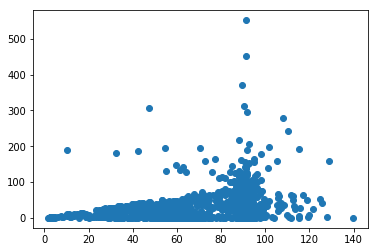

In [287]:
plt.scatter(dfc.zmass,dfc.nmass)

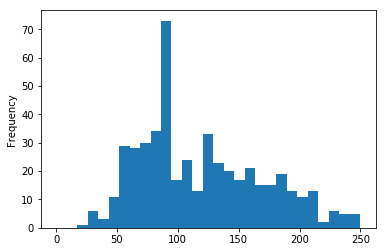

In [309]:
# dfc["hmass"].plot.hist(bins=np.linspace(0,250,50))
df = dfc.query("10<nmass<80")
df.hmass.plot.hist(bins=np.linspace(0,250,30))

Text(0.5, 1.0, 'data')

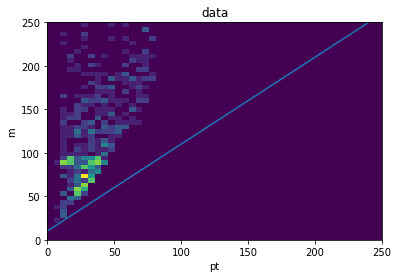

In [298]:
fig,ax = plt.subplots()
bins = [np.linspace(0,250,50),np.linspace(0,250,50)]
df = dfc.query("10<nmass<80")
# ax.hist2d(df["zmass"],df["nmass"],bins=bins,norm=LogNorm());
ax.hist2d(df["nmass"],df["hmass"],bins=bins)
ax.plot(bins[0],bins[0]+10)
ax.set_xlabel("pt")
ax.set_ylabel("m")
ax.set_title("data")